In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, choose_gauge_fixing, random_pauli, print_pauli_error, random_pauli_asym, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

In [19]:
rng = np.random.default_rng(72348)

In [65]:
# Compass Code Simulation
dims = [5, 7, 9, 11, 13, 15]
phys_err_rates_range = np.linspace(0.0001, 0.05, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = rng.integers(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:32<00:00, 25.48s/it]


In [4]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

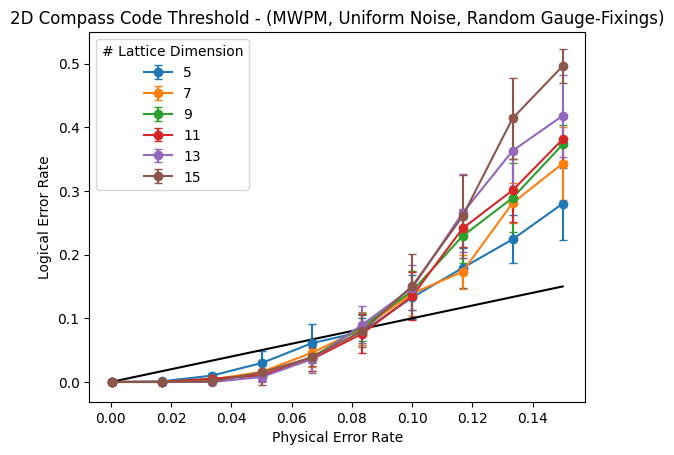

In [7]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

### Syndrome Size Weighting:
* We can weigh each edge of the decoding graph by the inverse of the sum of the size of the stabilizers corresponding to vertices adjacent to a given edge

In [8]:
def find_check_weight_for_qubit(pc_mat : np.array, index : int):
    check_indices = []
    for i, row in enumerate(pc_mat):
        if row[index] == 1:
            check_indices.append(i)
    check_weight = np.sum([np.sum([pc_mat[ind] for ind in check_indices])])
    return check_weight

def find_adjacent_syndrome_weights(pc_mat : np.array):
    weights = []
    for i in range(np.shape(pc_mat)[1]):
        weights.append(1/find_check_weight_for_qubit(pc_mat, i))
    return weights

In [9]:
# Compass Code Simulation
dims = [5, 7, 9, 11, 13, 15]
phys_err_rates_range = np.linspace(0.0001, 0.05, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = rng.integers(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                weight_x = find_adjacent_syndrome_weights(Hx)
                weight_z = find_adjacent_syndrome_weights(Hz)
                decodingX = Matching.from_check_matrix(Hx, weights=weight_x)
                decodingZ = Matching.from_check_matrix(Hz, weights=weight_z)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [05:17<00:00, 52.93s/it]


In [10]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_imp_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

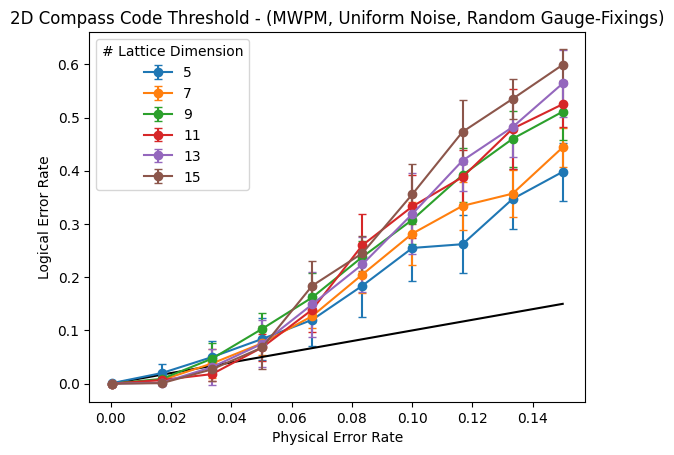

In [11]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('2D Compass Code Threshold - (MWPM, Uniform Noise, Random Gauge-Fixings)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

### BP-Matching
* Run BP to get vector of soft-decisions
* Use soft-decisions to weight decoding graph edges

In [22]:
dims = [5,7,9,11,13,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10
phys_err_rates_range = np.linspace(0, 0.08, 15)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        # lat = Lattice2D(dim, dim)
        # coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        # lat.color_lattice(coloring)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd0",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd0", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                # if (np.max(weightsX) > 20000000):
                #     weightsX = np.zeros((lat.size(),))
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                # if (np.max(weightsZ) > 20000000):
                #     weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_28320/1183240765.py:57: RuntimeWarning: invalid value encountered in divide
  weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
/tmp/ipykernel_28320/1183240765.py:60: RuntimeWarning: invalid value encountered in divide
  weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
100%|██████████| 6/6 [07:22<00:00, 73.73s/it] 


In [23]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_imp_mwpm_1', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

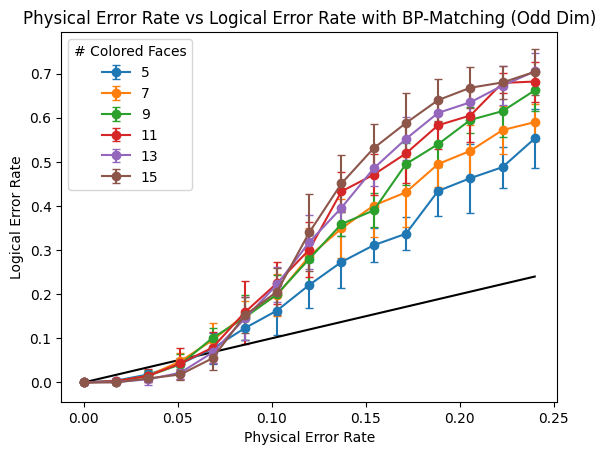

In [24]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Odd Dim)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

In [25]:
dims = [5,7,9,11,13,15]
num_faces_colored = [dim**2 for dim in dims]
num_guage_fixings = 15
phys_err_rates_range = np.linspace(0, 0.08, 15)
num_errors = 100 
logical_errors = {dim : np.zeros((num_guage_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        # lat = Lattice2D(dim, dim)
        # coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        # lat.color_lattice(coloring)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 7
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 7
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                # if (np.max(weightsX) > 20000000):
                #     weightsX = np.zeros((lat.size(),))
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                # if (np.max(weightsZ) > 20000000):
                #     weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_28320/3645385385.py:58: RuntimeWarning: invalid value encountered in divide
  weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
/tmp/ipykernel_28320/3645385385.py:61: RuntimeWarning: invalid value encountered in divide
  weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
100%|██████████| 6/6 [08:15<00:00, 82.66s/it] 


In [26]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_surface_code_code_imp_mwpm_1', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

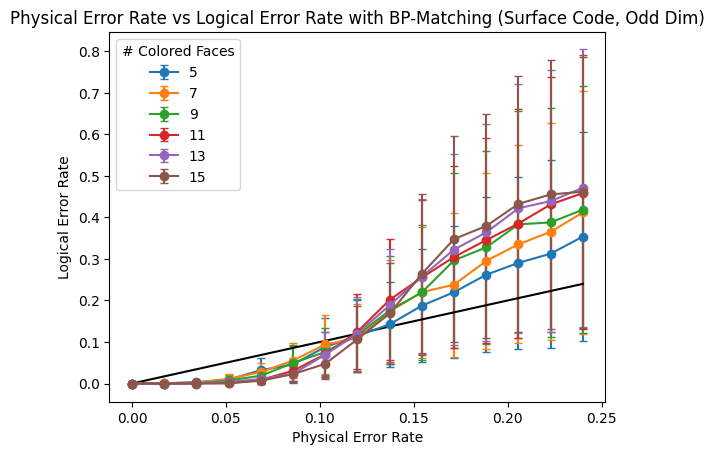

In [27]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Surface Code, Odd Dim)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

### Manhattan Distance Weighting:
* Weigh edges of decoder graph using manhattan distance of stabilizers

In [12]:
lat = Lattice2D(3,3)
coloring = np.random.randint(-1, 2, size=(3 - 1)**2)
lat.color_lattice(coloring)
print(lat.stabs)
print(lat)
for stab_group in lat.stabs:
    for stab in stab_group:
        print_pauli_error(stab, 3, 3)
        print('\n')

[['___XXXXXX', 'X__X_____', '_XX_XX___'], ['_ZZ______', 'ZZ_ZZ____', '______ZZ_', '____ZZ___', '_______ZZ']]
000---001---002
 |  ▓  |  ░  |
003---004---005
 |  ░  |  ░  |
006---007---008

_ | _ | _
X | X | X
X | X | X


X | _ | _
X | _ | _
_ | _ | _


_ | X | X
_ | X | X
_ | _ | _


_ | Z | Z
_ | _ | _
_ | _ | _


Z | Z | _
Z | Z | _
_ | _ | _


_ | _ | _
_ | _ | _
Z | Z | _


_ | _ | _
_ | Z | Z
_ | _ | _


_ | _ | _
_ | _ | _
_ | Z | Z




In [15]:
def find_check_for_qubit(pc_mat : np.array, index : int):
    check_indices = []
    for i, row in enumerate(pc_mat):
        if row[index] == 1:
            check_indices.append(i)
    return check_indices

def find_adjacent_syndrome_weights(pc_mat : np.array):
    weights = []
    for i in range(np.shape(pc_mat)[1]):
        weights.append(1/find_check_weight_for_qubit(pc_mat, i))
    return weights

def get_stab_center(stab, lat):
    dimX = lat.dimX 
    dimZ = lat.dimZ
    non_trivial_stab_pos = []
    for i in range(dimX):
        for j in range(dimZ):
            if (stab[j + i * dimZ] != '_'):
                non_trivial_stab_pos.append((i,j))
    min_x = np.min([p[0] for p in non_trivial_stab_pos])
    max_x = np.max([p[0] for p in non_trivial_stab_pos])
    min_y = np.min([p[1] for p in non_trivial_stab_pos])
    max_y = np.max([p[1] for p in non_trivial_stab_pos])
    print(min_x, max_x, min_y, max_y)
    center = ((max_x + min_x)/2, (max_y + min_y)/2)
    return center

def manhat_dist(stab_1, stab_2, lat):
    center_1 = get_stab_center(stab_1, lat)
    center_2 = get_stab_center(stab_2, lat)
    return np.abs(center_1[0] - center_2[0]) + np.abs(center_1[1] - center_2[1])

def get_all_distances(lat):
    Hx = pcheck_clipX(lat.pcheckX())
    Hz = pcheck_clipZ(lat.pcheckZ())
    X_stabs = lat.stabs[0]
    Z_stabs = lat.stabs[1]
    weightsX = []
    weightsZ = []
    print(Hx)
    for i in range(np.shape(Hx)[1]):
        print(find_check_for_qubit(Hx, i))
    


In [16]:
print(get_all_distances(lat))

[[0 0 0 1 1 1 1 1 1]
 [1 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]]
[1]
[2]
[2]
[0, 1]
[0, 2]
[0, 2]
[0]
[0]
[0]
None


In [22]:
# IDEA: Start with Surface-Like Code. Perform schedule-based gauge-fixing to converge towards optimal code for a given noise model in some number of rounds of mesaurmeents
#   * Consider noiseless mesaurement case with Biased depolarizing noise
#   * Then consider noisy mesaurement case with biased deplarizing noise
#   * Consider noiseless measurement case with dissipative noise
#   * Consider noisy measurement case with dissipative noise